In [2]:
!pip install librosa
!pip install noisereduce
!pip install scipy

In [1]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
# Load the audio file
file_path = "R1023_20231115_060003.wav"  # Change this to your actual file path
y, sr = librosa.load(file_path, sr=None)

# Apply a Band-Pass Filter (Keep bird frequencies: ~1kHz to 8kHz)
lowcut = 1000  # 1 kHz
highcut = 8000  # 8 kHz

def bandpass_filter(data, sr, lowcut, highcut, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# Noise Reduction using noisereduce
reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.8)

# Save the cleaned bird sound
output_file = "bird_sounds_extracted.wav"
sf.write(output_file, reduced_noise, sr)

print(f"Processed audio saved as {output_file}")

In [5]:
print(sr)

32000


In [4]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

# Load the audio file
file_path = "/content/R1023_20231115_060003.wav"  # Change this to your actual file path
y, sr = librosa.load(file_path, sr=None)

# Apply a Band-Pass Filter (Keep bird frequencies: ~1kHz to 8kHz)
lowcut = 1000  # 1 kHz
highcut = 8000  # 8 kHz

def bandpass_filter(data, sr, lowcut, highcut, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# Stronger Noise Reduction using noisereduce
reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.9)

# Spectral Subtraction for further noise removal
def spectral_subtraction(audio, noise_factor=0.05):
    stft = librosa.stft(audio)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_profile = np.mean(magnitude, axis=1, keepdims=True) * noise_factor
    enhanced_magnitude = np.maximum(magnitude - noise_profile, 0)
    return librosa.istft(enhanced_magnitude * np.exp(1j * phase))

cleaned_audio = spectral_subtraction(reduced_noise)

# Adaptive Gain Increase (Normalize & Amplify)
def adaptive_gain(audio, target_dB=-20):
    rms = np.sqrt(np.mean(audio ** 2))
    scalar = 10 ** ((target_dB - 20 * np.log10(rms)) / 20)
    return np.clip(audio * scalar, -1, 1)  # Prevent clipping

final_audio = adaptive_gain(cleaned_audio)

# Save the cleaned bird sound
output_file = "bird_sounds_extracted_enhanced.wav"
sf.write(output_file, final_audio, sr)

print(f"Processed audio saved as {output_file}")


Processed audio saved as bird_sounds_extracted_enhanced.wav


In [3]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

# Load the full 1-hour audio
file_path = "R1023_20231115_060003.wav"
y, sr = librosa.load(file_path, sr=None, duration=None)  # Ensure full duration is loaded

# Bandpass Filter (Preserves More Sound)
lowcut = 1000
highcut = 8000

def bandpass_filter(data, sr, lowcut, highcut, order=3):  # Lower order to preserve sound
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# Noise Reduction with Less Aggressive Reduction
reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.7)  # Less aggressive

# Spectral Subtraction (Avoid Over-Filtering)
def spectral_subtraction(audio, noise_factor=0.02):  # Reduce noise factor
    stft = librosa.stft(audio, n_fft=2048, hop_length=512)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_profile = np.mean(magnitude, axis=1, keepdims=True) * noise_factor
    enhanced_magnitude = np.maximum(magnitude - noise_profile, 0)
    return librosa.istft(enhanced_magnitude * np.exp(1j * phase), hop_length=512)  # Match hop_length

cleaned_audio = spectral_subtraction(reduced_noise)

# Adaptive Gain (Preserve Full Audio Length)
def adaptive_gain(audio, target_dB=-25):  # Reduce gain to avoid clipping
    rms = np.sqrt(np.mean(audio ** 2))
    scalar = 10 ** ((target_dB - 20 * np.log10(rms)) / 20)
    return np.clip(audio * scalar, -1, 1)

final_audio = adaptive_gain(cleaned_audio)

# Ensure the Output is the Same Length as Input
if len(final_audio) < len(y):
    padding = np.zeros(len(y) - len(final_audio))
    final_audio = np.concatenate((final_audio, padding))

# Save the fixed file
output_file = "bird_sounds_extracted_full.wav"
sf.write(output_file, final_audio, sr)

print(f"Processed full 1-hour audio saved as {output_file}")


Processed full 1-hour audio saved as bird_sounds_extracted_full.wav


In [5]:
import matplotlib.pyplot as plt

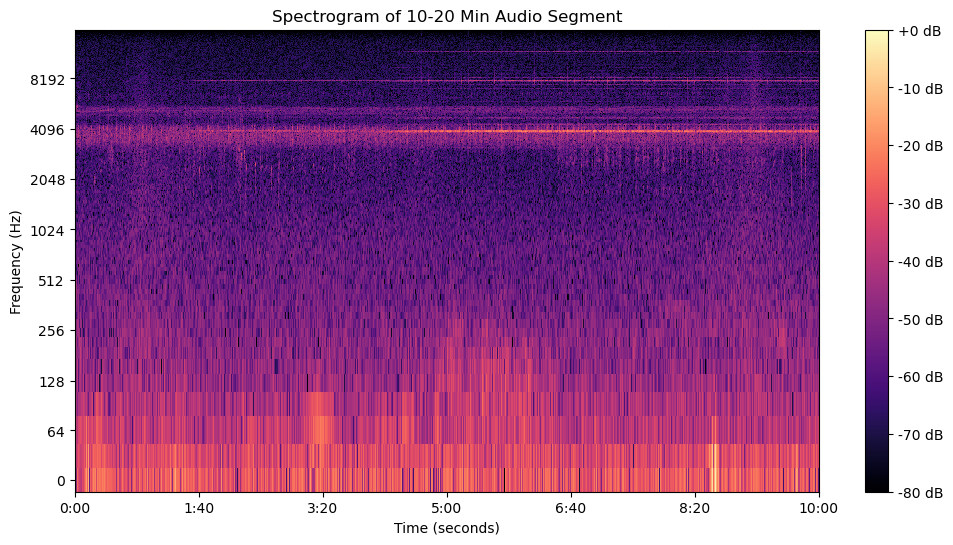

In [7]:
# Extract 10-20 min segment
start_time = 10 * 60  # 10 minutes in seconds
end_time = 20 * 60    # 20 minutes in seconds

start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

segment_audio = y[start_sample:end_sample]

# Generate Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(segment_audio, n_fft=1024, hop_length=1024)), ref=np.max)

# Plot Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, sr=sr, hop_length=1024, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of 10-20 Min Audio Segment")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [6]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

# Load the full 1-hour audio
file_path = "R1023_20231115_060003.wav"
y, sr = librosa.load(file_path, sr=None, duration=None)  # Load full duration

# Bandpass Filter (Preserves More Sound)
lowcut = 1000  # Hz
highcut = 8000  # Hz

def bandpass_filter(data, sr, lowcut, highcut, order=3):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# **Detecting Ambient Noise Profile**
# Taking a small sample from the start (first 5 seconds) assuming it's mostly noise
noise_sample = filtered_audio[:sr * 10]

# **Noise Reduction with More Aggressive Reduction for Continuous Noise**
reduced_noise = nr.reduce_noise(y=filtered_audio, y_noise=noise_sample, sr=sr, prop_decrease=0.9)

## Notch Filter Design
def notch_filter(data, sr, freq, bw=100, order=2):  # bw is bandwidth, adjust as needed
    f0 = freq  # Frequency to be removed
    Q = f0 / bw  # Quality factor
    b, a = signal.iirnotch(f0 / (sr / 2), Q) # No order here
    return signal.filtfilt(b, a, data)


def spectral_subtraction(audio_chunk, sr, noise_sample):
    # 1. Notch Filter FIRST (remove the specific tone)
    notched_chunk = notch_filter(audio_chunk, sr, 8192)  # Remove 8192 Hz tone

    # 2. THEN Noise Reduction (for the remaining broadband noise)
    reduced_chunk = nr.reduce_noise(y=notched_chunk, y_noise=noise_sample, sr=sr, prop_decrease=0.9)

    # 3. Spectral Subtraction (for any residual noise)
    stft = librosa.stft(reduced_chunk, n_fft=2048, hop_length=512, dtype=np.float32)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_profile = np.mean(magnitude, axis=1, keepdims=True) * 0.01
    enhanced_magnitude = np.maximum(magnitude - noise_profile, 0).astype(np.float32)
    cleaned_chunk = librosa.istft(enhanced_magnitude * np.exp(1j * phase), hop_length=512)

    return cleaned_chunk

def process_audio_in_chunks(audio, sr, chunk_duration=30, noise_duration=10):  # Added noise_duration
    cleaned_audio = []
    chunk_samples = int(chunk_duration * sr)
    noise_samples = int(noise_duration * sr) # Number of samples for initial noise profile

    # Initial Noise Profile (from the beginning of the audio)
    initial_noise_sample = audio[:noise_samples]

    for i in range(0, len(audio), chunk_samples):
        audio_chunk = audio[i:i + chunk_samples]

        # Update Noise Profile (You can make this more sophisticated later)
        if i == 0:
            noise_sample = initial_noise_sample
        #elif i % (chunk_samples * 2) == 0:  # Update noise every 2 chunks (example)
        #    noise_start = max(0, i - noise_samples) # Ensure we don't go before the beginning
        #    noise_sample = audio[noise_start:i] # Take the last noise_duration seconds before the current chunk
        else:
            noise_sample = initial_noise_sample # For now, keep using the initial noise sample

        cleaned_chunk = spectral_subtraction(audio_chunk, sr, noise_sample)
        cleaned_audio.extend(cleaned_chunk)

    return np.array(cleaned_audio)


cleaned_audio = process_audio_in_chunks(filtered_audio, sr)

# **Adaptive Gain (Preserve Full Audio Length)**
def adaptive_gain(audio, target_dB=-25):
    rms = np.sqrt(np.mean(audio ** 2))
    scalar = 10 ** ((target_dB - 20 * np.log10(rms)) / 20)
    return np.clip(audio * scalar, -1, 1)

final_audio = adaptive_gain(cleaned_audio)

# Ensure the Output is the Same Length as Input (important after chunking)
if len(final_audio) < len(y):
    padding = np.zeros(len(y) - len(final_audio))
    final_audio = np.concatenate((final_audio, padding))
elif len(final_audio) > len(y): # Handle the case where the output is longer
    final_audio = final_audio[:len(y)]  # Truncate to match input length

# Save the final cleaned audio
output_file = "bird_sounds_extracted_chunk_ambient_noise.wav"
sf.write(output_file, final_audio, sr)

print(f"Processed full 1-hour audio with ambient noise removed saved as {output_file}")


Processed full 1-hour audio with ambient noise removed saved as bird_sounds_extracted_chunk_ambient_noise.wav


In [8]:
import librosa
import numpy as np
import soundfile as sf
lowcut = 1000  # Hz
highcut = 8000  # Hz

def bandpass_filter(data, sr, lowcut, highcut, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

def extract_frequency_range(audio_file, sr, lowcut=1100, highcut=4000):
    """
    Extracts a specific frequency range from an audio file.

    Args:
        audio_file (str): Path to the input audio file.
        sr (int): Sample rate of the audio. If None, it will be determined.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Higher cutoff frequency in Hz.

    Returns:
        numpy.ndarray: The extracted audio data.
        int: The sample rate of the extracted audio (same as input)
        or None if there's an error.
    """
    try:
        y, sr = librosa.load(audio_file, sr=sr)  # Load the audio file
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None, None

    # 1. STFT
    filtered_audio = bandpass_filter(y, sr, lowcut, highcut)
    # Noise Reduction using noisereduce
    reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.8)
    stft = librosa.stft(reduced_noise, n_fft=2048, hop_length=512)  # Adjust n_fft and hop_length if needed
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=2048)  # Get the frequency bins
    print(np.abs(frequencies - lowcut))
    print(np.abs(frequencies - highcut))

    # 2. Find indices corresponding to the desired frequency range
    low_idx = np.argmin(np.abs(frequencies - lowcut))
    high_idx = np.argmin(np.abs(frequencies - highcut))

    # 3. Zero out the STFT outside the desired range
    stft_filtered = stft.copy()
    stft_filtered[:np.argmin(lowcut), :] = 0  # Zero out frequencies below lowcut
    stft_filtered[np.argmin(highcut) + 1:, :] = 0  # Zero out frequencies above highcut


    # 4. Inverse STFT
    y_filtered = librosa.istft(stft_filtered, hop_length=512)

    return y_filtered, sr


# Example usage:
audio_file = "R1023_20231115_060003.wav"  # Replace with your audio file path
sr = None # Let librosa detect the sample rate or set it manually.

filtered_audio, sr = extract_frequency_range(audio_file, sr)

if filtered_audio is not None and sr is not None:
    output_file = "filtered_audio5.wav"
    sf.write(output_file, filtered_audio, sr)  # Save the filtered audio
    print(f"Filtered audio saved to {output_file}")

[ 1100.     1084.375  1068.75  ... 14868.75  14884.375 14900.   ]
[ 4000.     3984.375  3968.75  ... 11968.75  11984.375 12000.   ]
Filtered audio saved to filtered_audio5.wav


In [10]:
import librosa
import soundfile as sf
import numpy as np
from scipy.signal import butter, lfilter

def apply_bandpass_filter(audio_file, output_file, lowcut, highcut, order=5):
    """Applies a bandpass filter (lowcut and highcut) to an audio file.

    Args:
        audio_file: Path to the input audio file.
        output_file: Path to save the filtered audio.
        lowcut: Lower cutoff frequency (Hz).
        highcut: Higher cutoff frequency (Hz).
        order: Order of the Butterworth filter (higher order = steeper cutoff).
    """

    # 1. Load audio
    y, sr = librosa.load(audio_file, sr=None)  # Load with original sample rate

    # 2. Design the Butterworth filter
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandpass')  # Bandpass filter

    # 3. Apply the filter
    y_filtered = lfilter(b, a, y)

    # 4. Normalize (optional but recommended)
    y_filtered = y_filtered / np.max(np.abs(y_filtered)) # prevents clipping

# 5. Save the filtered audio
    sf.write(output_file, y_filtered, sr)

# Example Usage:
input_audio = "R1023_20231115_060003.wav"
output_audio = "filtered_audio2.wav"

lowcut_freq = 500  # Example: 500 Hz lowcut
highcut_freq = 4000 # Example: 5000 Hz highcut

apply_bandpass_filter(input_audio, output_audio, lowcut_freq, highcut_freq)
print(f"Filtered audio saved to {output_audio}")


# --- For Highpass only (removing low frequencies) ---
# def apply_highpass_filter(audio_file, output_file, cutoff, order=5):
#     nyquist = 0.5 * sr
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
#     y_filtered = lfilter(b, a, y)
#     y_filtered = y_filtered / np.max(np.abs(y_filtered))
#     sf.write(output_file, y_filtered, sr)

# # Example Highpass:
# # apply_highpass_filter(input_audio, "highpass_audio.wav", 1000) # Cutoff at 1kHz


# # --- For Lowpass only (removing high frequencies) ---
# def apply_lowpass_filter(audio_file, output_file, cutoff, order=5):
#     nyquist = 0.5 * sr
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
#     y_filtered = lfilter(b, a, y)
#     y_filtered = y_filtered / np.max(np.abs(y_filtered))
#     sf.write(output_file, y_filtered, sr)

# Example Lowpass:
# apply_lowpass_filter(input_audio, "lowpass_audio.wav", 2000) # Cutoff at 2kHz

Filtered audio saved to filtered_audio2.wav
